In [25]:
from main import Simplify
import os
import json
import re
import sys
import time

import cv2
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import torchvision as tv
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np

from aegan import AEGAN

BATCH_SIZE = 32
LATENT_DIM = 32

device = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = tv.transforms.Compose([
    tv.transforms.RandomAffine(0, translate=(5 / 96, 5 / 96), fill=(255, 255, 255)),
    # tv.transforms.ColorJitter(hue=0.5),
    tv.transforms.RandomHorizontalFlip(p=0.5),
    # Simplify(),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5,), (0.5, 0.5, 0.5,))
])
dataset = ImageFolder(
    root="data_cleared",
    transform=transform
)
dataloader = DataLoader(dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        num_workers=1,
                        drop_last=True
                        )

noise_fn = lambda x: torch.randn((x, LATENT_DIM), device=device)

gan = AEGAN(
    LATENT_DIM,
    noise_fn,
    dataloader,
    device=device,
    batch_size=BATCH_SIZE,
    channels_cnt=3,
    colors_cnt=16
)

In [26]:
gan.load(os.path.join("data_cleared_linear_upsampling_colorspace_stolen_discriminator_results", "checkpoints"), 499)

In [3]:
seed = noise_fn(100)

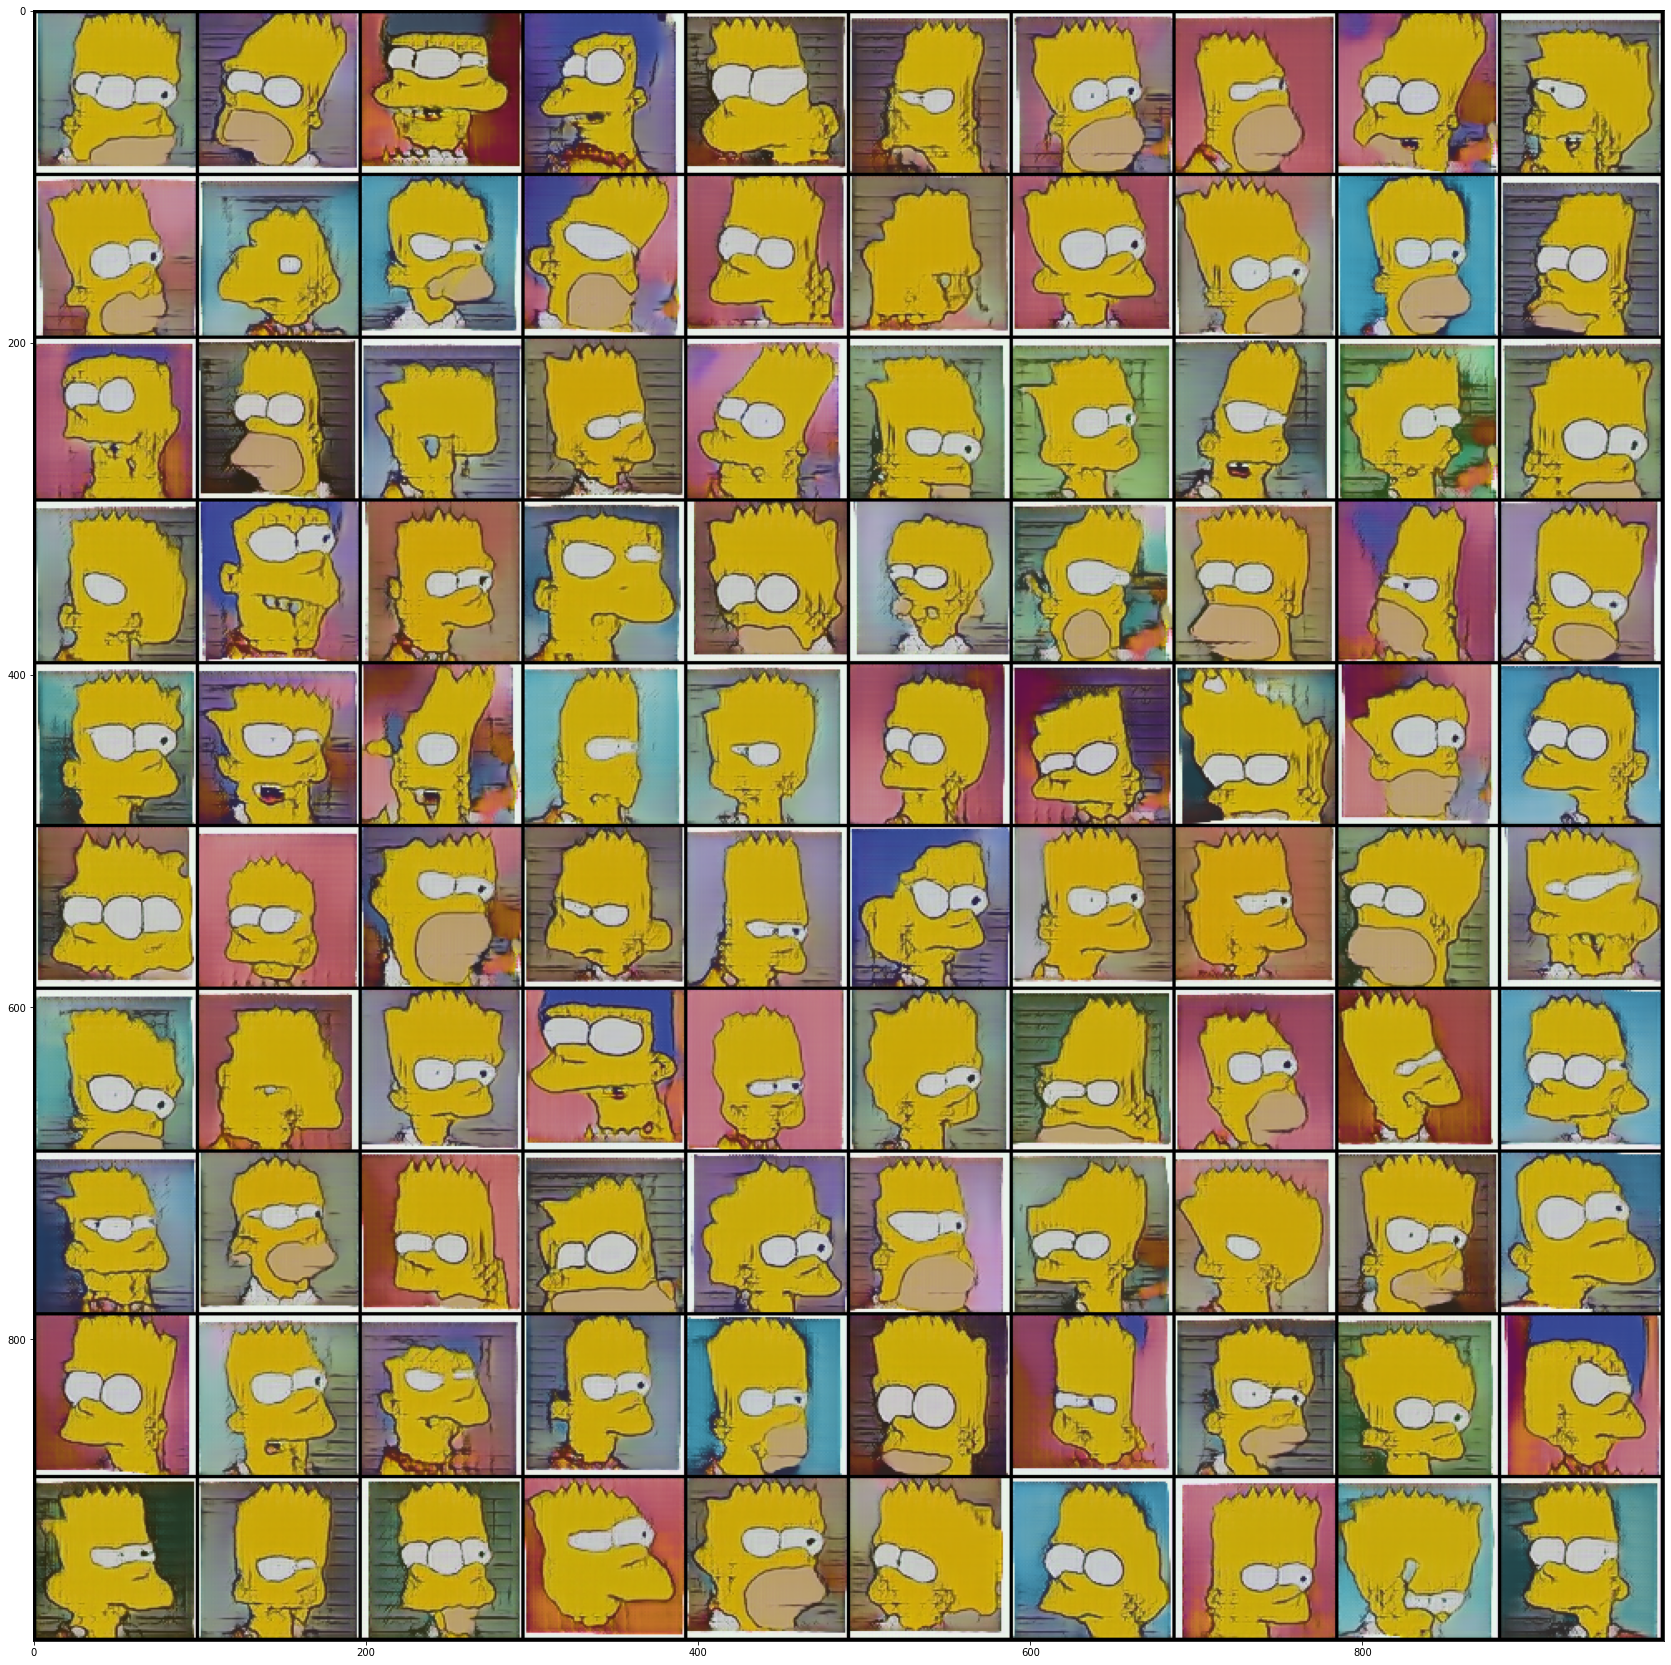

In [8]:
gan.generator.eval()
with torch.no_grad():
    generated = gan.generator(seed)

# generated = generated[0]
generated = tv.utils.make_grid(generated, normalize=True, nrow=10, ncol=10)


# for thresh in np.linspace(0, 1, 10):
def to_image(generated):
    # restored = restore_simplified(generated, threshold=0.9)
    generated = generated.cpu().numpy().transpose([1, 2, 0])
    # generated = cv2.cvtColor(generated, cv2.COLOR_RGB2BGR)
    # generated = (generated + 1) / 2
    generated = (generated * 255).astype(np.uint8)
    # restored = cv2.fastNlMeansDenoisingColored(restored, None, 10, 10, 7, 21)
    return generated


restored = to_image(generated)
plt.figure(figsize=(30, 30))
plt.imshow(restored)
plt.show()

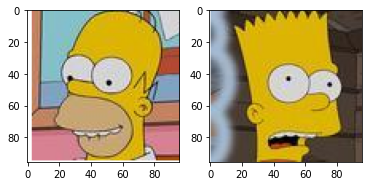

In [123]:
data_iter = iter(dataloader)
images = next(data_iter)[0]
img1 = images[0]
img1 = img1[None, :, : ,:]
img2 = images[15]  # 5 is marge
img2 = img2[None, :, : ,:]
# img2 = next(data_iter)[0]

# img1 = (img1 + 1) / 2
# img2 = (img2 + 1) / 2

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow((img1[0].numpy().transpose([1, 2, 0]) + 1) / 2)
ax2.imshow((img2[0].numpy().transpose([1, 2, 0]) + 1) / 2)
plt.show()
# Image.fromarray(to_image(img1[0])).show()

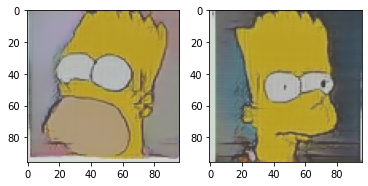

In [124]:
gan.encoder.eval()
gan.generator.eval()

# img1, img2 = img1[None, :, : ,:], img2[None, :, : ,:]

with torch.no_grad():
    img1_latent = gan.encoder(img1)
    img2_latent = gan.encoder(img2)
    img1_restored = gan.generator(img1_latent)
    img2_restored = gan.generator(img2_latent)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow((img1_restored[0].numpy().transpose([1, 2, 0]) + 1) / 2)
ax2.imshow((img2_restored[0].numpy().transpose([1, 2, 0]) + 1) / 2)
plt.show()

In [44]:
from tqdm import tqdm

steps_cnt = 10
images = []

img1_latent_copy = img1_latent.clone()
with torch.no_grad():
    for i, (latent1_value, latent2_value) in tqdm(enumerate(zip(img1_latent[0], img2_latent[0]))):
        for step_idx in range(steps_cnt):
            img1_latent_copy[0][i] += (latent2_value - latent1_value) / steps_cnt
            step_img = gan.generator(img1_latent_copy)
            step_img = ((step_img[0].numpy().transpose([1, 2, 0]) + 1) / 2 * 255).astype(np.uint8)
            step_img = Image.fromarray(step_img)
            images.append(step_img)

32it [00:34,  1.08s/it]


In [45]:
images[0].save("colorSpace_interpolation_steps.gif", save_all=True, append_images=images[1:], duration=50, loop=0)

In [92]:
steps_cnt = 30
looped = True
images = []

img1_latent_copy = img1_latent.clone()
with torch.no_grad():
    for step_idx in tqdm(range(steps_cnt)):
        img1_latent_copy += (img2_latent - img1_latent) / steps_cnt
        step_img = gan.generator(img1_latent_copy)
        step_img = ((step_img[0].numpy().transpose([1, 2, 0]) + 1) / 2 * 255).astype(np.uint8)
        step_img = Image.fromarray(step_img)
        images.append(step_img)

if looped:
    images += reversed(images)

100%|██████████| 30/30 [00:06<00:00,  5.00it/s]


In [91]:
images[0].save("colorSpace_interpolation_straight.gif", save_all=True, append_images=images[1:], duration=50, loop=0)

In [79]:
img2_latent_copy = img2_latent.clone()
latent_vec_id = 30
steps_cnt = 200
step_size = 0.1
direction = -1
images = []

# plt.figure(figsize=[10, 20])
# fig, ax = plt.subplots(2, steps_cnt // 2, figsize=[20, 20])

with torch.no_grad():
    img2_latent_copies = [img2_latent.clone() for _ in range(32)]
    for step_idx in tqdm(range(steps_cnt)):
        step_images = []
        for latent_vec_id in range(32):
            img2_latent_copy = img2_latent_copies[latent_vec_id]
            img2_latent_copy[0][latent_vec_id] += step_size * direction
            step_img = gan.generator(img2_latent_copy)
            step_images.append(step_img)

        generated = torch.cat(step_images)
        generated = tv.utils.make_grid(generated, normalize=True, nrow=8, ncol=4)
        generated = to_image(generated)
        generated = Image.fromarray(generated)
        images.append(generated)

    images[0].save(f"colorSpace_interpolation_moves.gif", save_all=True, append_images=images[1:], duration=50, loop=0)

# plt.show()

100%|██████████| 200/200 [10:43<00:00,  3.22s/it]
